## Investigation of intra-label consistency

In this experiment, we investigate model scores (as given by the classification head of a RetinaNet model).

For this purpose, we trained networks in three-fold cross-validation on the training sets of both label sets. 
The training of the networks can be seen in the following notebooks:

TUPAC original labels:
- RetinaNet-TUPAC-CrossValidationTrainingset_Batch1.ipynb
- RetinaNet-TUPAC-CrossValidationTrainingset_Batch2.ipynb
- RetinaNet-TUPAC-CrossValidationTrainingset_Batch3.ipynb

Alternative Labels:
- RetinaNet-TUPAC_AL-CrossValidationTrainingset_Batch1.ipynb
- RetinaNet-TUPAC_AL-CrossValidationTrainingset_Batch2.ipynb
- RetinaNet-TUPAC_AL-CrossValidationTrainingset_Batch3.ipynb

The inference was run as:

``python Inference-LowThres.py RetinaNet-TUPAC-CrossValidationTrainingset-Batch1-512s.pth TUPAC_stitched.sqlite test_lowcut_b1 test slidelist_test_TUPAC_CrossValidataion_batch1.p stitched/
python Inference-LowThres.py RetinaNet-TUPAC-CrossValidationTrainingset-Batch2-512s.pth TUPAC_stitched.sqlite test_lowcut_b2 test slidelist_test_TUPAC_CrossValidataion_batch2.p stitched/
python Inference-LowThres.py RetinaNet-TUPAC-CrossValidationTrainingset-Batch3-512s.pth TUPAC_stitched.sqlite test_lowcut_b3 test slidelist_test_TUPAC_CrossValidataion_batch3.p stitched/``

and, respectively:

``python Inference-LowThres.py RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch1-512s.pth TUPAC_stitched.sqlite test_al_lowcut_b1 test slidelist_test_TUPAC_CrossValidataion_batch1.p stitched/
python Inference-LowThres.py RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch2-512s.pth TUPAC_stitched.sqlite test_al_lowcut_b2 test slidelist_test_TUPAC_CrossValidataion_batch2.p stitched/
python Inference-LowThres.py RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch3-512s.pth TUPAC_stitched.sqlite test_al_lowcut_b3 test slidelist_test_TUPAC_CrossValidataion_batch3.p stitched/```

Here, we match the mitotic figures of the respective data set to the scores predicted by the models.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from SlideRunner.dataAccess.database import *
import os
import sys

We define a matching function, based on a KDtree with a distance(radius) of 25 pixels.

In [2]:
from sklearn.neighbors import KDTree

def match(dataset1 : np.ndarray, dataset2 : np.ndarray):


        center1_x = dataset1[:, 0] if dataset1.shape[0]>0 else np.array([])
        center1_y = dataset1[:, 1] if dataset1.shape[0]>0 else np.array([])

        center2_x = dataset2[:, 0] if dataset2.shape[0]>0 else np.array([])
        center2_y = dataset2[:, 1] if dataset2.shape[0]>0 else np.array([])
        
        uids1 = dataset1[:,2] if dataset1.shape[0]>0 else np.array([])
        uids2 = dataset2[:,2] if dataset2.shape[0]>0 else np.array([])
        
        mapping_DS1_to_DS2 = {}
        mapping_DS2_to_DS1 = {}
        
        isDS1 = np.zeros(center1_x.shape[0]+center2_x.shape[0])
        isDS1[0:center1_x.shape[0]]=1 # mark as detection, rest ist GT

        center_x = np.hstack((center1_x, center2_x))
        center_y = np.hstack((center1_y, center2_y))
        uids = np.hstack((uids1, uids2))

        radius=25
        
        # set up kdtree 
        X = np.dstack((center_x, center_y))[0]

        if (X.shape[0]==0):
            return 0,0,0,0,({},{},[],[])

        
        try:
            tree = KDTree(X)
        except:
            print('Shapes of X: ',X.shape)
            raise Error()

        ind = tree.query_radius(X, r=radius)

        annotationMatches = {x: 0 for x in np.where(isDS1==0)[0]}
        DetectionMatchesAnnotation = {x: 0 for x in np.where(isDS1==1)[0]}

        # check: already used results
        alreadyused=[]
        for i in ind:
            if len(i)==0:
                continue
            if np.any(isDS1[i]) and np.any(isDS1[i]==0):
                # at least 1 from DS1 and one from DS2 --> mark all as matches
                fromDS1 = i[isDS1[i]==1][0]
                fromDS2 = i[isDS1[i]==0][0]
                for j in range(len(i)):
                    if not isDS1[i][j]: # is from DS2
                        if i[j] not in annotationMatches:
                            print('Missing key ',j, 'in annotationWasDetected')
                            raise ValueError('Ijks')
                        annotationMatches[i[j]] = 1
                        mapping_DS2_to_DS1[uids[i[j]]] = uids[fromDS1]
                        mapping_DS1_to_DS2[uids[fromDS1]] = uids[i[j]]
                        
                    else:
                        if i[j] not in DetectionMatchesAnnotation:
                            print('Missing key ',j, 'in DetectionMatchesAnnotation')
                            raise ValueError('Ijks')

                        DetectionMatchesAnnotation[i[j]] = 1

        
        matching = np.sum([annotationMatches[x]==1 for x in annotationMatches.keys()])
        nonlyDS2 = np.sum([annotationMatches[x]==0 for x in annotationMatches.keys()])

        nonlyDS1 = np.sum([DetectionMatchesAnnotation[x]==0 for x in DetectionMatchesAnnotation.keys()])
        onlyDS1 = uids[isDS1==1][[DetectionMatchesAnnotation[x]==0 for x in DetectionMatchesAnnotation.keys()]]
        onlyDS2 = uids[isDS1==0][[annotationMatches[x]==0 for x in annotationMatches.keys()]]
        
        F1 = 2*matching/(2*matching + nonlyDS1 + nonlyDS2)

        assert(matching==len(mapping_DS2_to_DS1.keys()))
        assert(nonlyDS1 == len(onlyDS1))
        assert(nonlyDS2 == len(onlyDS2))
        return F1, matching, nonlyDS1, nonlyDS2, (mapping_DS1_to_DS2, mapping_DS2_to_DS1,onlyDS1,onlyDS2)

    


In [3]:
offprob=0.00

In [4]:
import pickle
results_testset = pickle.load(open('RetinaNet-TUPAC-CrossValidationTrainingset-Batch1-512s.pth-test_lowcut_b1-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
detections_probs = []
detections_probs_TUPAC = []
detections_hardexamples=[]
slides_tested = []
detections_probs_agreed=[]
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    slides_tested.append(fname)
    
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)
        

    05_stitched1.tif F1: 0.800000, matching:    4, only TUPAC_AL:    0, only TUPAC:    2 (   1 NM)
    06_stitched1.tif F1: 0.816901, matching:   87, only TUPAC_AL:   30, only TUPAC:    9 (   8 NM)
    13_stitched1.tif F1: 0.500000, matching:    1, only TUPAC_AL:    0, only TUPAC:    2 (   0 NM)
    17_stitched1.tif F1: 0.500000, matching:    2, only TUPAC_AL:    0, only TUPAC:    4 (   2 NM)
    21_stitched1.tif F1: 0.606250, matching:   97, only TUPAC_AL:  108, only TUPAC:   18 (  17 NM)
    23_stitched1.tif F1: 0.724138, matching:   21, only TUPAC_AL:    5, only TUPAC:   11 (   9 NM)
              25.tif F1: 0.000000, matching:    0, only TUPAC_AL:    3, only TUPAC:    1 (   0 NM)
              26.tif F1: 0.000000, matching:    0, only TUPAC_AL:    4, only TUPAC:    0 (   0 NM)
              29.tif F1: 0.800000, matching:    2, only TUPAC_AL:    1, only TUPAC:    0 (   0 NM)
              30.tif F1: 0.500000, matching:    1, only TUPAC_AL:    2, only TUPAC:    0 (   0 NM)
          

In [5]:
import pickle
results_testset = pickle.load(open('RetinaNet-TUPAC-CrossValidationTrainingset-Batch2-512s.pth-test_lowcut_b2-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
#detections_probs = []
#detections_probs_TUPAC = []
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    
    slides_tested.append(fname)
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)


    01_stitched1.tif F1: 0.690476, matching:   58, only TUPAC_AL:   37, only TUPAC:   15 (  13 NM)
    02_stitched1.tif F1: 0.761905, matching:   32, only TUPAC_AL:   15, only TUPAC:    5 (   4 NM)
    08_stitched1.tif F1: 1.000000, matching:    3, only TUPAC_AL:    0, only TUPAC:    0 (   0 NM)
    09_stitched1.tif F1: 0.666667, matching:    1, only TUPAC_AL:    0, only TUPAC:    1 (   1 NM)
    14_stitched1.tif F1: 0.315789, matching:    3, only TUPAC_AL:    0, only TUPAC:   13 (   2 NM)
    15_stitched1.tif F1: 0.852941, matching:   58, only TUPAC_AL:   12, only TUPAC:    8 (   7 NM)
    16_stitched1.tif F1: 0.666667, matching:    6, only TUPAC_AL:    3, only TUPAC:    3 (   2 NM)
              24.tif F1: 0.761905, matching:    8, only TUPAC_AL:    3, only TUPAC:    2 (   1 NM)
              27.tif F1: 0.750000, matching:    3, only TUPAC_AL:    2, only TUPAC:    0 (   0 NM)
              28.tif F1: 1.000000, matching:    1, only TUPAC_AL:    0, only TUPAC:    0 (   0 NM)
          

In [6]:
import pickle
results_testset = pickle.load(open('RetinaNet-TUPAC-CrossValidationTrainingset-Batch3-512s.pth-test_lowcut_b3-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
#detections_probs = []
#detections_probs_TUPAC = []
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    
    slides_tested.append(fname)
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)


    03_stitched1.tif F1: 0.551724, matching:    8, only TUPAC_AL:    3, only TUPAC:   10 (   6 NM)
    04_stitched1.tif F1: 0.674033, matching:  183, only TUPAC_AL:  136, only TUPAC:   41 (  38 NM)
    07_stitched1.tif F1: 0.625698, matching:   56, only TUPAC_AL:   55, only TUPAC:   12 (  10 NM)
    11_stitched1.tif F1: 0.560000, matching:    7, only TUPAC_AL:    3, only TUPAC:    8 (   6 NM)
    12_stitched1.tif F1: 0.545455, matching:    3, only TUPAC_AL:    0, only TUPAC:    5 (   5 NM)
    18_stitched1.tif F1: 0.745536, matching:  167, only TUPAC_AL:   69, only TUPAC:   45 (  42 NM)
    22_stitched1.tif F1: 0.790698, matching:   51, only TUPAC_AL:    6, only TUPAC:   21 (  20 NM)
              35.tif F1: 0.000000, matching:    0, only TUPAC_AL:    1, only TUPAC:    0 (   0 NM)
              39.tif F1: 0.400000, matching:    1, only TUPAC_AL:    3, only TUPAC:    0 (   0 NM)
              44.tif F1: 0.461538, matching:    3, only TUPAC_AL:    7, only TUPAC:    0 (   0 NM)
          

In [7]:
len(detections_probs), len(detections_probs_TUPAC)

(760, 309)

Median model score, agreed mitoses: 0.26642605662345886
Median model score, TUPAC-only mitoses: 0.3259458839893341
Median model score, hard examples: 0.07257059961557388
Median model score, new mitotic fig: 0.26642605662345886


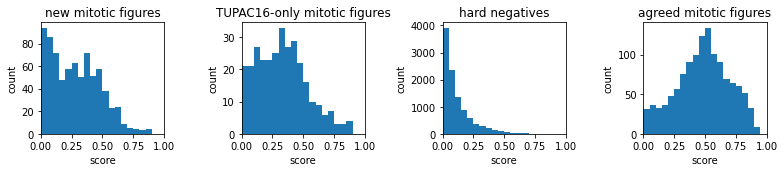

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4, figsize=(11,2.5))
ax[0].hist(detections_probs,np.arange(0.0,1.01,0.05)), 
ax[1].hist(detections_probs_TUPAC,np.arange(0.0,1.01,0.05))
ax[2].hist(detections_hardexamples,np.arange(0.0,1.01,0.05))
ax[3].hist(detections_probs_agreed,np.arange(0.0,1.01,0.05))
for k in range(4):
    ax[k].set_xlim([0.00,1.0])
    yl = ax[k].get_ylim()
    ax[k].set_ylim(yl)
    ax[k].set_xlabel('score')
    ax[k].set_ylabel('count')
    
print('Median model score, agreed mitoses:', np.median(detections_probs))
print('Median model score, TUPAC-only mitoses:', np.median(detections_probs_TUPAC))
print('Median model score, hard examples:', np.median(detections_hardexamples))
print('Median model score, new mitotic fig:', np.median(detections_probs))

ax[0].set_title('new mitotic figures')
ax[1].set_title('TUPAC16-only mitotic figures')
ax[2].set_title('hard negatives')
ax[3].set_title('agreed mitotic figures')
plt.tight_layout()
plt.savefig('Histograms_crossvalidation_TUPACorig.svg')

In [9]:
len(detections_probs_agreed)

1239

# AlternnativeLabels data set

In [10]:
results_testset = pickle.load(open('RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch3-512s.pth-test_al_lowcut_b3-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
detections_probs = []
detections_probs_TUPAC = []
detections_hardexamples=[]
slides_tested = []
detections_probs_agreed=[]
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    slides_tested.append(fname)
    
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)
        

    03_stitched1.tif F1: 0.551724, matching:    8, only TUPAC_AL:    3, only TUPAC:   10 (   6 NM)
    04_stitched1.tif F1: 0.674033, matching:  183, only TUPAC_AL:  136, only TUPAC:   41 (  38 NM)
    07_stitched1.tif F1: 0.625698, matching:   56, only TUPAC_AL:   55, only TUPAC:   12 (  10 NM)
    11_stitched1.tif F1: 0.560000, matching:    7, only TUPAC_AL:    3, only TUPAC:    8 (   6 NM)
    12_stitched1.tif F1: 0.545455, matching:    3, only TUPAC_AL:    0, only TUPAC:    5 (   5 NM)
    18_stitched1.tif F1: 0.745536, matching:  167, only TUPAC_AL:   69, only TUPAC:   45 (  42 NM)
    22_stitched1.tif F1: 0.790698, matching:   51, only TUPAC_AL:    6, only TUPAC:   21 (  20 NM)
              35.tif F1: 0.000000, matching:    0, only TUPAC_AL:    1, only TUPAC:    0 (   0 NM)
              39.tif F1: 0.400000, matching:    1, only TUPAC_AL:    3, only TUPAC:    0 (   0 NM)
              44.tif F1: 0.461538, matching:    3, only TUPAC_AL:    7, only TUPAC:    0 (   0 NM)
          

In [11]:
results_testset = pickle.load(open('RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch2-512s.pth-test_al_lowcut_b2-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
#detections_probs = []
#detections_probs_TUPAC = []
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    
    slides_tested.append(fname)
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)


    01_stitched1.tif F1: 0.690476, matching:   58, only TUPAC_AL:   37, only TUPAC:   15 (  13 NM)
    02_stitched1.tif F1: 0.761905, matching:   32, only TUPAC_AL:   15, only TUPAC:    5 (   4 NM)
    08_stitched1.tif F1: 1.000000, matching:    3, only TUPAC_AL:    0, only TUPAC:    0 (   0 NM)
    09_stitched1.tif F1: 0.666667, matching:    1, only TUPAC_AL:    0, only TUPAC:    1 (   1 NM)
    14_stitched1.tif F1: 0.315789, matching:    3, only TUPAC_AL:    0, only TUPAC:   13 (   2 NM)
    15_stitched1.tif F1: 0.852941, matching:   58, only TUPAC_AL:   12, only TUPAC:    8 (   7 NM)
    16_stitched1.tif F1: 0.666667, matching:    6, only TUPAC_AL:    3, only TUPAC:    3 (   2 NM)
              24.tif F1: 0.761905, matching:    8, only TUPAC_AL:    3, only TUPAC:    2 (   1 NM)
              27.tif F1: 0.750000, matching:    3, only TUPAC_AL:    2, only TUPAC:    0 (   0 NM)
              28.tif F1: 1.000000, matching:    1, only TUPAC_AL:    0, only TUPAC:    0 (   0 NM)
          

In [12]:
results_testset = pickle.load(open('RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch1-512s.pth-test_al_lowcut_b1-inference_results_boxes.p','rb'))
DB_TUPAC = Database().open('TUPAC_stitched.sqlite')
DB = Database().open('TUPAC_alternativeLabels_augmented.sqlite')
mapping_TUPACtoTUPACAL={}
for [fname,tupacSlideID] in DB_TUPAC.execute('SELECT filename,uid from Slides order by filename').fetchall():
    newDBSlide = DB.findSlideWithFilename(fname,'')
    DB.loadIntoMemory(newDBSlide)
    DB_TUPAC.loadIntoMemory(tupacSlideID)
    if fname not in results_testset:
        continue
    res_testset = results_testset[fname]
    probabilities = np.array([[0.5*(x[0]+x[2]),0.5*(x[1]+x[3]),(idx, x[5])] for idx,x in enumerate(res_testset)])
    
    annos_tupac = np.array([[DB_TUPAC.annotations[x].x1,DB_TUPAC.annotations[x].y1,DB_TUPAC.annotations[x].uid] for x in DB_TUPAC.annotations.keys()])
    annos_tupac_al = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==1 and DB.annotations[x].deleted==0])
    annos_tupac_al_nonmit = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass==2])
    annos_tupac_al_all = np.array([[DB.annotations[x].x1,DB.annotations[x].y1,DB.annotations[x].uid] for x in DB.annotations.keys() if DB.annotations[x].agreedClass>0])

    mtch=match(annos_tupac_al,annos_tupac)
    mtch_all=match(annos_tupac_al_all,annos_tupac)
    mtch2=match(annos_tupac_al_nonmit,annos_tupac)
    
    slides_tested.append(fname)
    if (annos_tupac_al.shape[0]==0):
        continue
    
    (mapping_TUPACtoTUPACAL[fname], mapping_DS2_to_DS1,onlyTUPACAL,onlyTUPAC) = mtch[4]
    
    annosOnlyInTUPAC_AL = annos_tupac_al[np.in1d(annos_tupac_al[:,2], onlyTUPACAL),:]
    annosOnlyInTUPAC = annos_tupac[np.in1d(annos_tupac[:,2], onlyTUPAC),:] if annos_tupac.shape[0]>0 else np.array([])
    annosMatched = annos_tupac[np.in1d(annos_tupac[:,2], list(mapping_TUPACtoTUPACAL[fname].values())),:] if annos_tupac.shape[0]>0 else np.array([])
    match_probs_TUPACALnewMitosis = match(annosOnlyInTUPAC_AL, probabilities)
    match_probs_TUPACnewMitosis = match(annosOnlyInTUPAC, probabilities)
    match_probs_TUPACHardExamples = match(annos_tupac_al_nonmit, probabilities)
    match_probs_TUPACmatched = match(annosMatched, probabilities)
    
    print('%20s' % fname,'F1: %4f, matching: %4d, only TUPAC_AL: %4d, only TUPAC: %4d (%4d NM)' % (mtch[0:4]+mtch2[1:2]))
    
    detections_probs += [x[1] for x in match_probs_TUPACALnewMitosis[4][0].values()]
    detections_probs_TUPAC += [x[1] for x in match_probs_TUPACnewMitosis[4][0].values()]
    detections_hardexamples += [x[1] for x in match_probs_TUPACHardExamples[4][0].values()]
    detections_probs_agreed += [x[1] for x in match_probs_TUPACmatched[4][0].values()]

    for k in range(int(match_probs_TUPACALnewMitosis[2])):
        detections_probs.append(offprob)
    
    for k in range(int(match_probs_TUPACnewMitosis[2])):
        detections_probs_TUPAC.append(offprob)
    
    for k in range(int(match_probs_TUPACHardExamples[2])):
        detections_hardexamples.append(offprob)

    for k in range(int(match_probs_TUPACmatched[2])):
        detections_probs_agreed.append(offprob)


    05_stitched1.tif F1: 0.800000, matching:    4, only TUPAC_AL:    0, only TUPAC:    2 (   1 NM)
    06_stitched1.tif F1: 0.816901, matching:   87, only TUPAC_AL:   30, only TUPAC:    9 (   8 NM)
    13_stitched1.tif F1: 0.500000, matching:    1, only TUPAC_AL:    0, only TUPAC:    2 (   0 NM)
    17_stitched1.tif F1: 0.500000, matching:    2, only TUPAC_AL:    0, only TUPAC:    4 (   2 NM)
    21_stitched1.tif F1: 0.606250, matching:   97, only TUPAC_AL:  108, only TUPAC:   18 (  17 NM)
    23_stitched1.tif F1: 0.724138, matching:   21, only TUPAC_AL:    5, only TUPAC:   11 (   9 NM)
              25.tif F1: 0.000000, matching:    0, only TUPAC_AL:    3, only TUPAC:    1 (   0 NM)
              26.tif F1: 0.000000, matching:    0, only TUPAC_AL:    4, only TUPAC:    0 (   0 NM)
              29.tif F1: 0.800000, matching:    2, only TUPAC_AL:    1, only TUPAC:    0 (   0 NM)
              30.tif F1: 0.500000, matching:    1, only TUPAC_AL:    2, only TUPAC:    0 (   0 NM)
          

Median model score, agreed mitoses: 0.5029786229133606
Median model score, TUPAC-only mitoses: 0.2839334309101105
Median model score, hard examples: 0.0658361092209816
Median model score, new mitotic fig: 0.5029786229133606


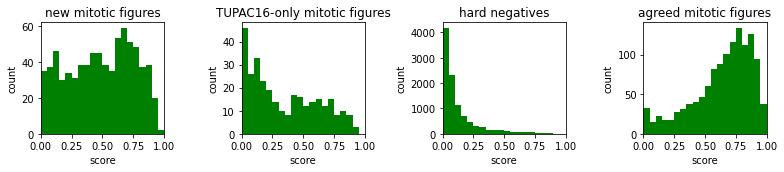

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4, figsize=(11,2.5))
ax[0].hist(detections_probs,np.arange(0.0,1.01,0.05),color='green'), 
ax[1].hist(detections_probs_TUPAC,np.arange(0.0,1.01,0.05),color='green')
ax[2].hist(detections_hardexamples,np.arange(0.0,1.01,0.05),color='green')
ax[3].hist(detections_probs_agreed,np.arange(0.0,1.01,0.05),color='green')
print('Median model score, agreed mitoses:', np.median(detections_probs))
print('Median model score, TUPAC-only mitoses:', np.median(detections_probs_TUPAC))
print('Median model score, hard examples:', np.median(detections_hardexamples))
print('Median model score, new mitotic fig:', np.median(detections_probs))

for k in range(4):
    ax[k].set_xlim([0.00,1.0])
    yl = ax[k].get_ylim()
    ax[k].set_ylim(yl)
    ax[k].set_xlabel('score')
    ax[k].set_ylabel('count')

    

ax[0].set_title('new mitotic figures')
ax[1].set_title('TUPAC16-only mitotic figures')
ax[2].set_title('hard negatives')
ax[3].set_title('agreed mitotic figures')
plt.tight_layout()
plt.savefig('Histograms_crossvalidation_AL.svg')